# Leios simulation analysis at tag `leios-2025w25`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## TPS experiment

In [2]:
label <- "Rust simulator, mini-mainnet, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/bw/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `Bandwidth [Mb/s]`:=factor(paste(`Bandwidth [Mb/s]`, "Mb/s"), levels=paste(c(1,3,10,30,100,300,1000), "Mb/s"))]
lifecycle %>% summary

 Simulator     Bandwidth [Mb/s] Kind                 Item      
 Rust:91178   1 Mb/s   :    0   RB:   22   0           :    2  
              3 Mb/s   :    0   EB:   48   0-node-220  :    2  
              10 Mb/s  :46549   IB:  781   1           :    2  
              30 Mb/s  :    0   TX:90327   1-node-158-0:    2  
              100 Mb/s :    0              1-node-209-0:    2  
              300 Mb/s :    0              1-node-498-0:    2  
              1000 Mb/s:44629              (Other)     :91166  
    Size [B]        References       Created [s]        To IB [s]     
 Min.   :     8   Min.   : 0.0000   Min.   :  0.001   Min.   : 62.13  
 1st Qu.:   431   1st Qu.: 0.0000   1st Qu.: 93.594   1st Qu.:110.13  
 Median :   923   Median : 1.0000   Median :128.114   Median :141.13  
 Mean   :  2954   Mean   : 0.7943   Mean   :128.087   Mean   :138.54  
 3rd Qu.:  2012   3rd Qu.: 1.0000   3rd Qu.:162.235   3rd Qu.:169.13  
 Max.   :327984   Max.   :10.0000   Max.   :199.548   Max.   :

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

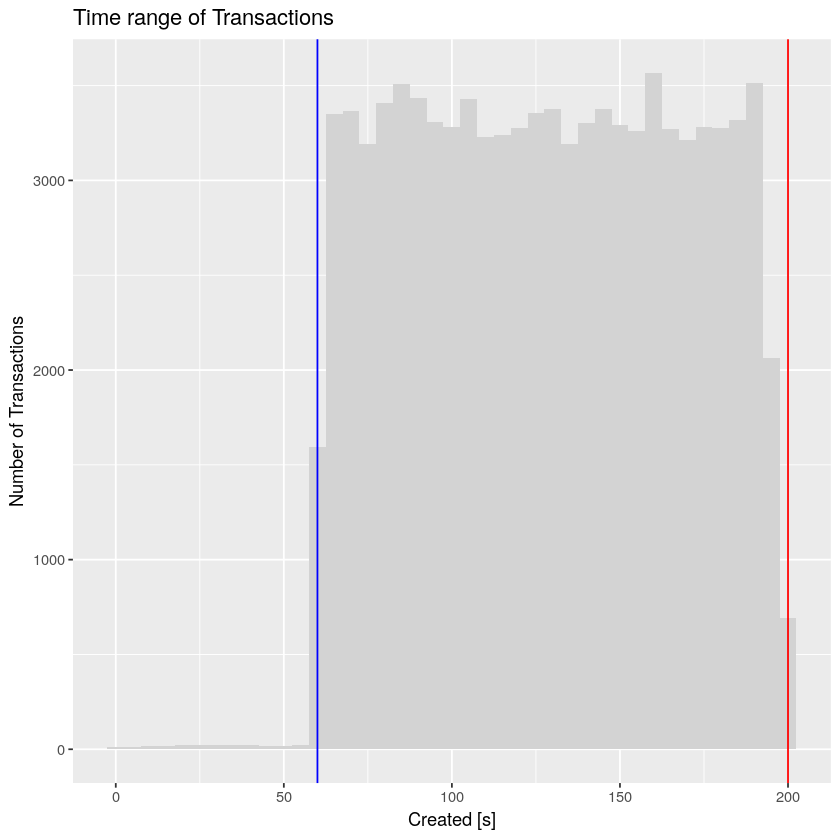

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/327680
    ),
    .(`Bandwidth [Mb/s]`)
]

Bandwidth [Mb/s],Demand [tx/s],Demand [MB/s],Demand [IB/s]
<fct>,<dbl>,<dbl>,<dbl>
10 Mb/s,329.4357,0.5587716,1.705236
1000 Mb/s,315.7571,0.5353507,1.633761


#### Size of persisted data

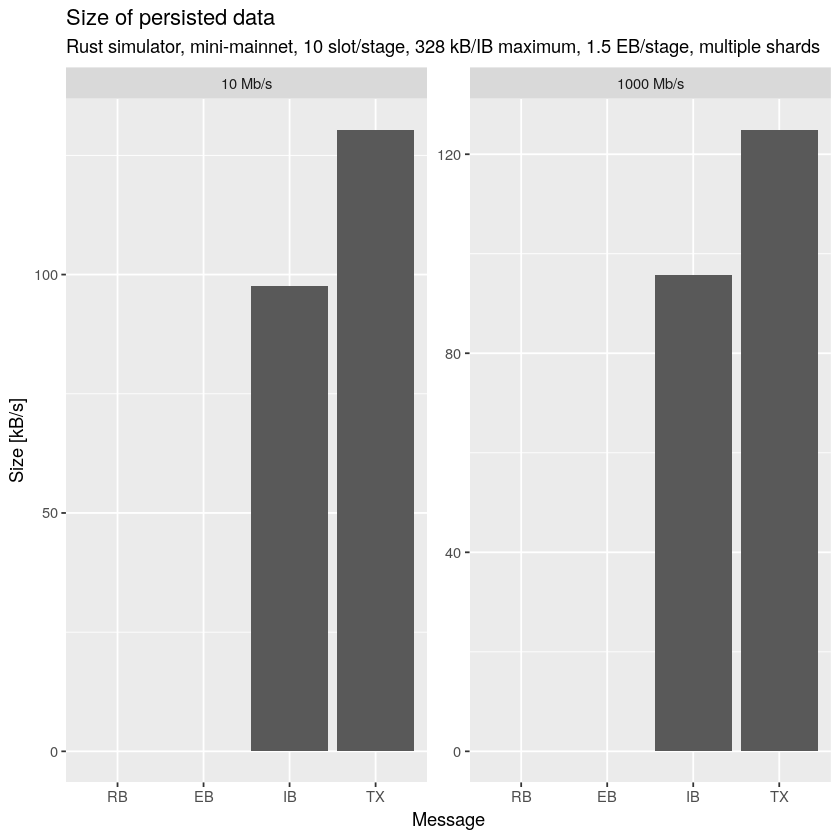

In [7]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Bandwidth [Mb/s]`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`Bandwidth [Mb/s]` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [8]:
ggsave("plots/bw/sizes.png", units="in", dpi=150, width=8, height=6)

In [9]:
ggsave("plots/bw/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

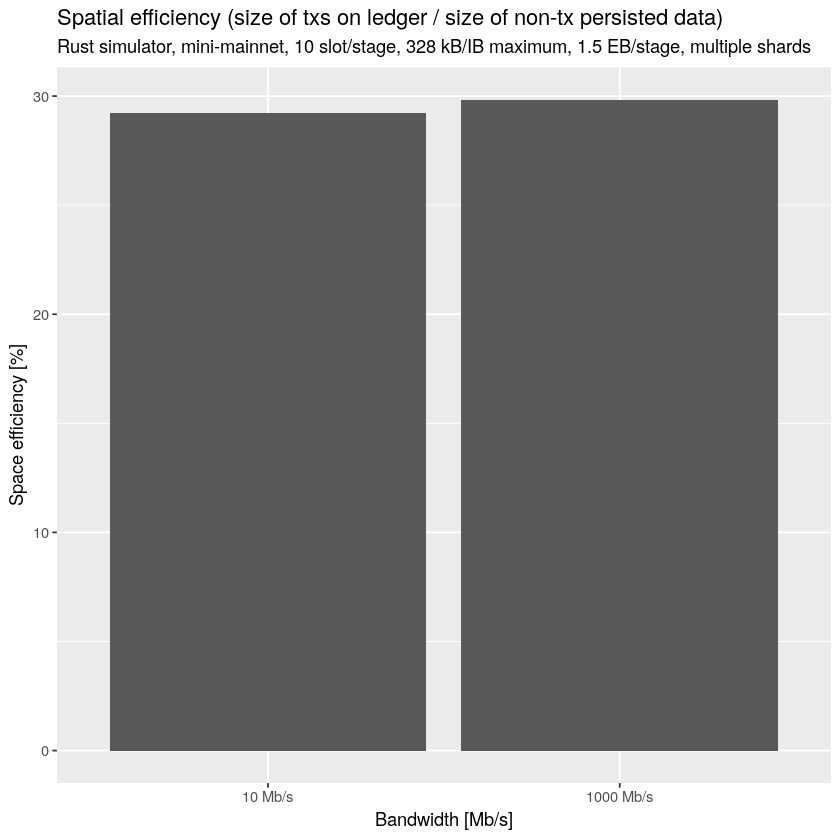

In [10]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Bandwidth [Mb/s]`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Bandwidth [Mb/s]`)
        ],
        on=c("Bandwidth [Mb/s]")
    ][, .(`Bandwidth [Mb/s]`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Bandwidth [Mb/s]`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [11]:
ggsave("plots/bw/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [12]:
ggsave("plots/bw/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

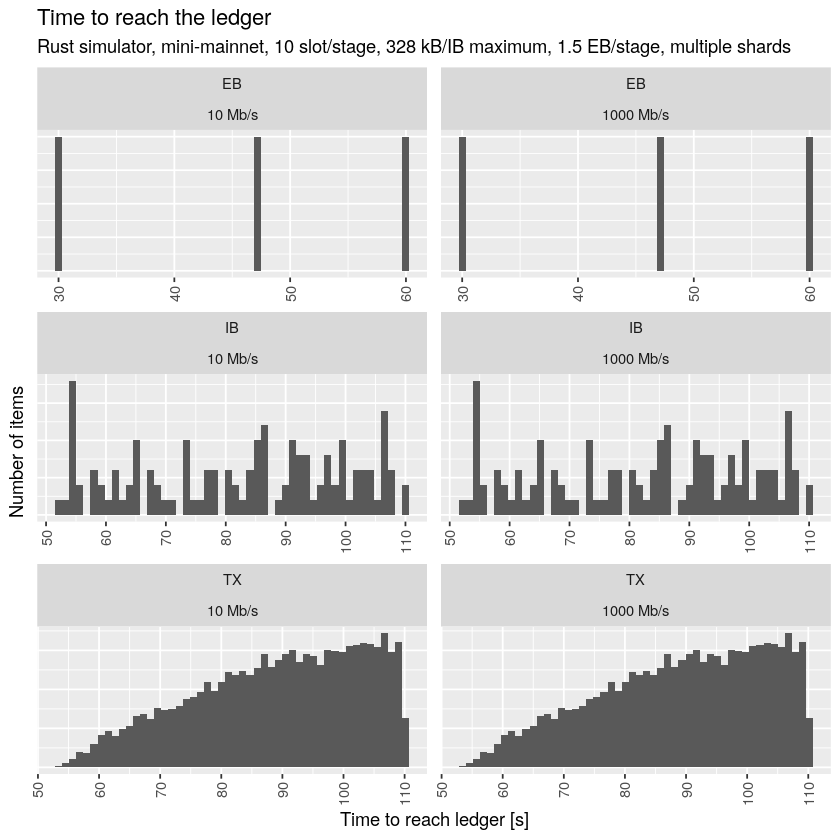

In [13]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [14]:
ggsave("plots/bw/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("plots/bw/reach-rb.svg", units="in", dpi=150, width=8, height=6)

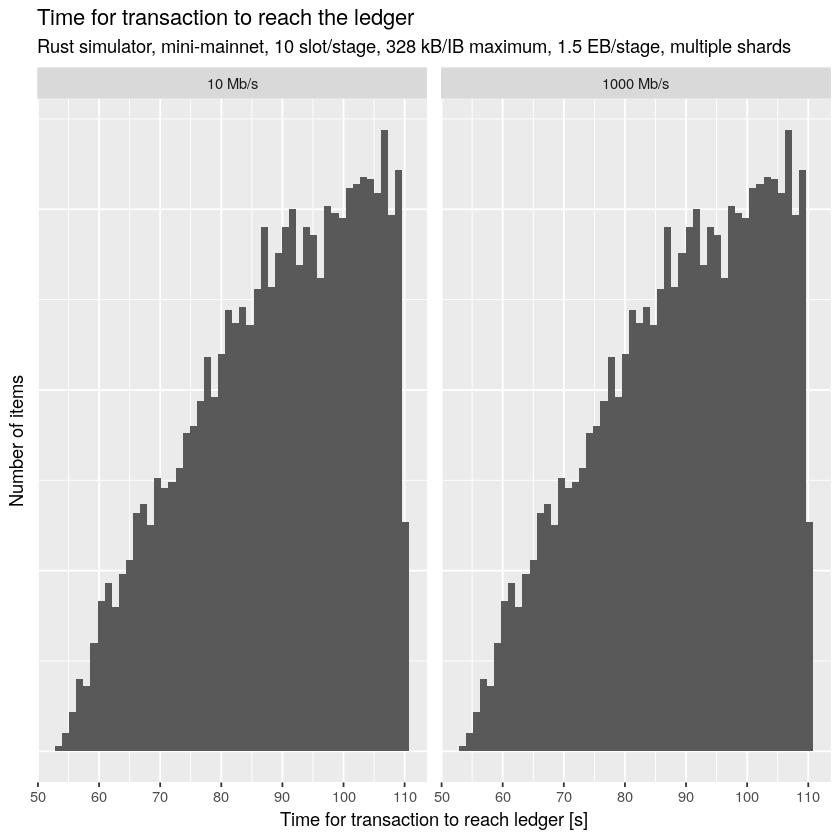

In [16]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `Bandwidth [Mb/s]`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [17]:
ggsave("plots/bw/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("plots/bw/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

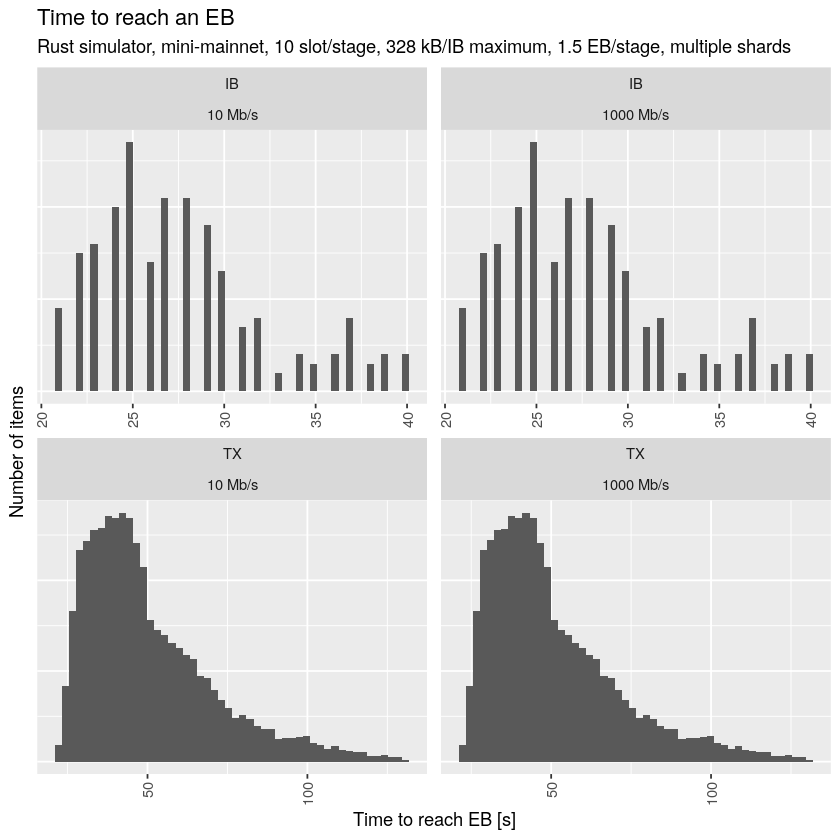

In [19]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=2) +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [20]:
ggsave("plots/bw/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [21]:
ggsave("plots/bw/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

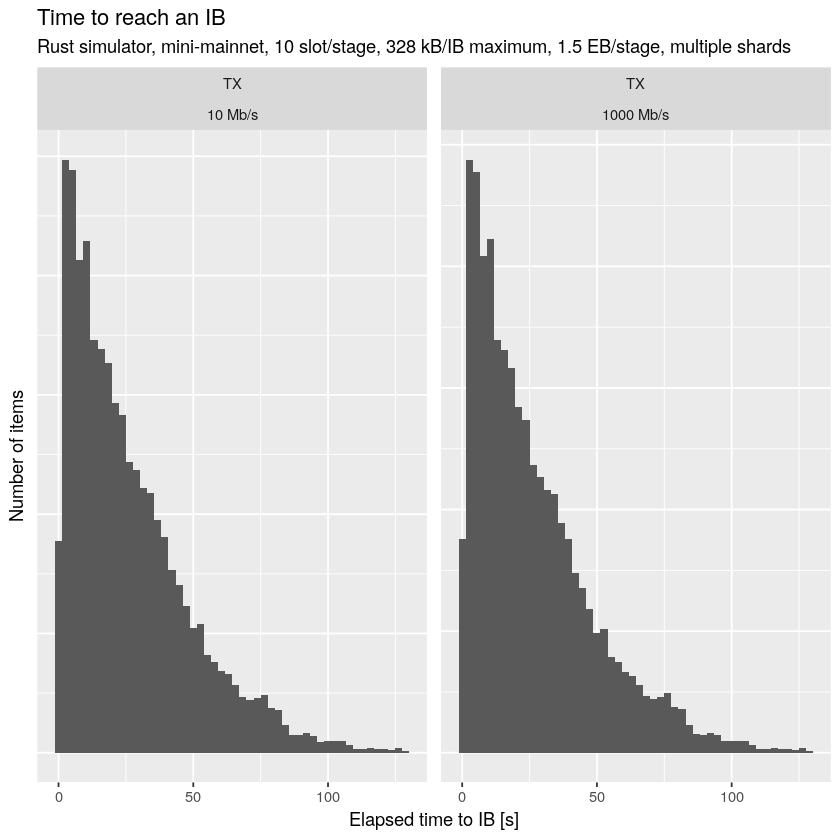

In [22]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", ncol=3) +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [23]:
ggsave("plots/bw/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [24]:
ggsave("plots/bw/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

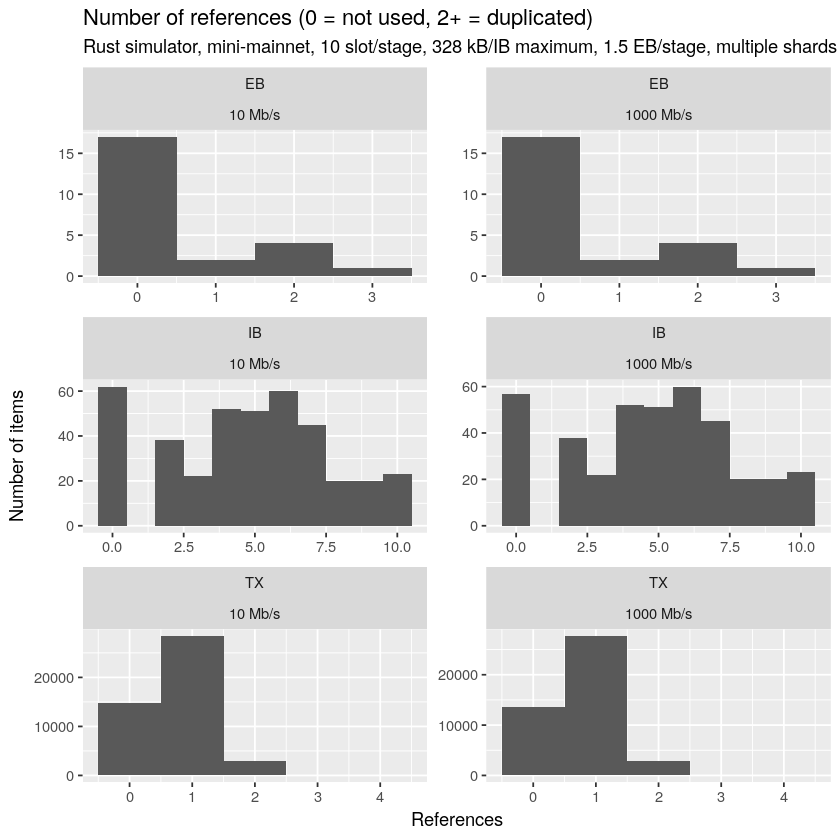

In [25]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [26]:
ggsave("plots/bw/references.png", units="in", dpi=150, width=8, height=6)

In [27]:
ggsave("plots/bw/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [28]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [29]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Bandwidth [Mb/s]`
    )
][order(`Bandwidth [Mb/s]`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [30]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)]

#### Transactions reaching the ledger

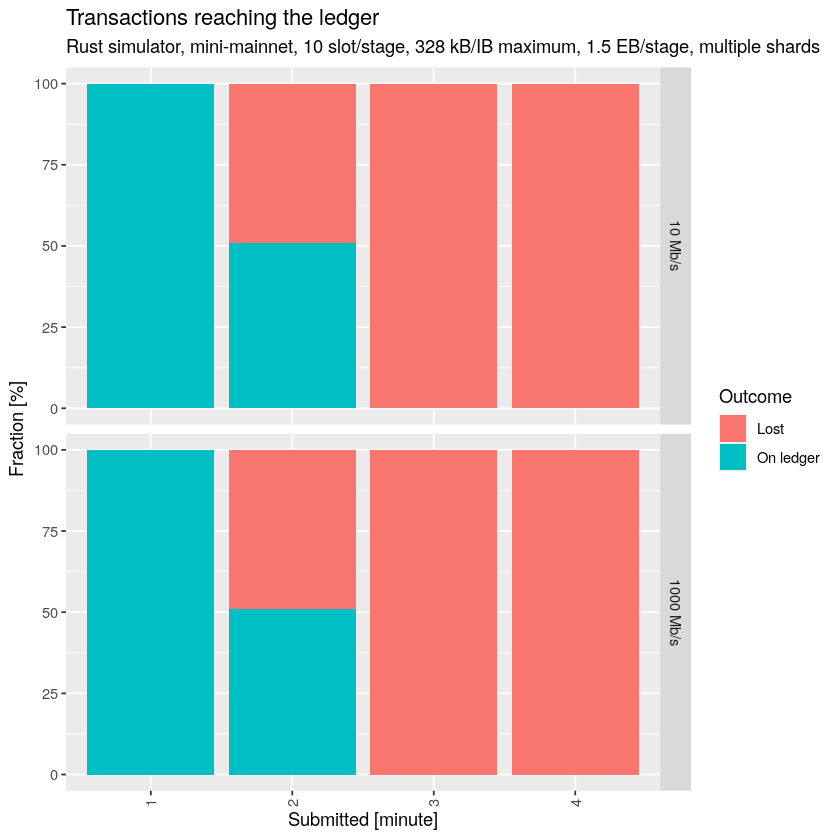

In [31]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)],
        id.vars=c("Bandwidth [Mb/s]", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Bandwidth [Mb/s]`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Bandwidth [Mb/s]` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [32]:
ggsave("plots/bw/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [33]:
ggsave("plots/bw/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

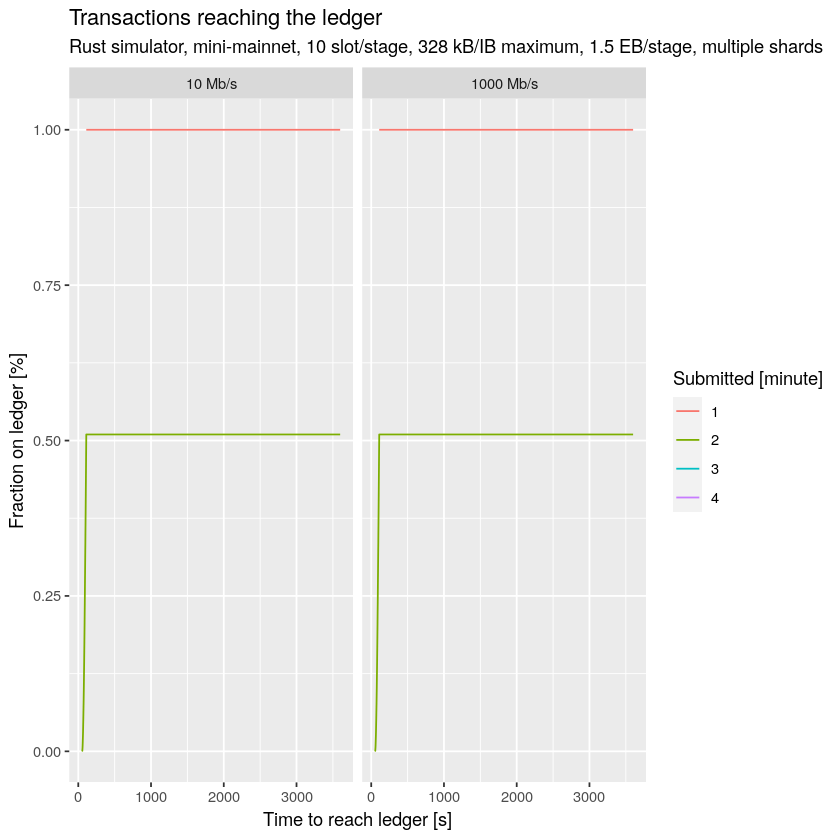

In [34]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)],
            on=c("Bandwidth [Mb/s]", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Bandwidth [Mb/s]`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`Bandwidth [Mb/s]` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [35]:
ggsave("plots/bw/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [36]:
ggsave("plots/bw/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [37]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [38]:
resources <- fread("results/bw/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 Simulator   Bandwidth [Mb/s]       Node        Egress [B]       
 Rust:1500   Min.   :  10     node-0  :   2   Min.   :   199606  
             1st Qu.:  10     node-1  :   2   1st Qu.:  6478325  
             Median : 505     node-10 :   2   Median :102098900  
             Mean   : 505     node-100:   2   Mean   :134595532  
             3rd Qu.:1000     node-101:   2   3rd Qu.:195141765  
             Max.   :1000     node-102:   2   Max.   :787477469  
                              (Other) :1488                      
    Disk [B]       Total CPU [s]   Maximum CPU [s/s]
 Min.   :      0   Min.   :116.5   Min.   :1.367    
 1st Qu.:      0   1st Qu.:118.5   1st Qu.:1.601    
 Median :      0   Median :120.0   Median :1.737    
 Mean   :  77475   Mean   :120.3   Mean   :1.713    
 3rd Qu.:      0   3rd Qu.:122.2   3rd Qu.:1.753    
 Max.   :1503890   Max.   :122.6   Max.   :2.200    
                                                    

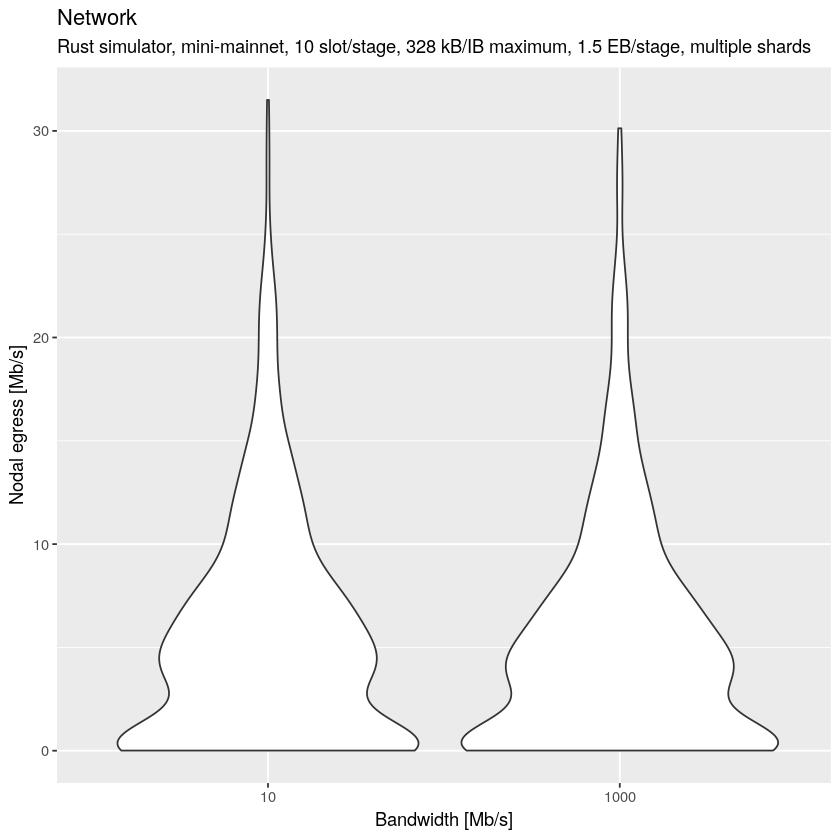

In [39]:
ggplot(
    resources[, .(`Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Bandwidth [Mb/s]`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    ggtitle("Network", label)

In [40]:
ggsave("plots/bw/network.png", units="in", dpi=150, width=9.5, height=5.5)

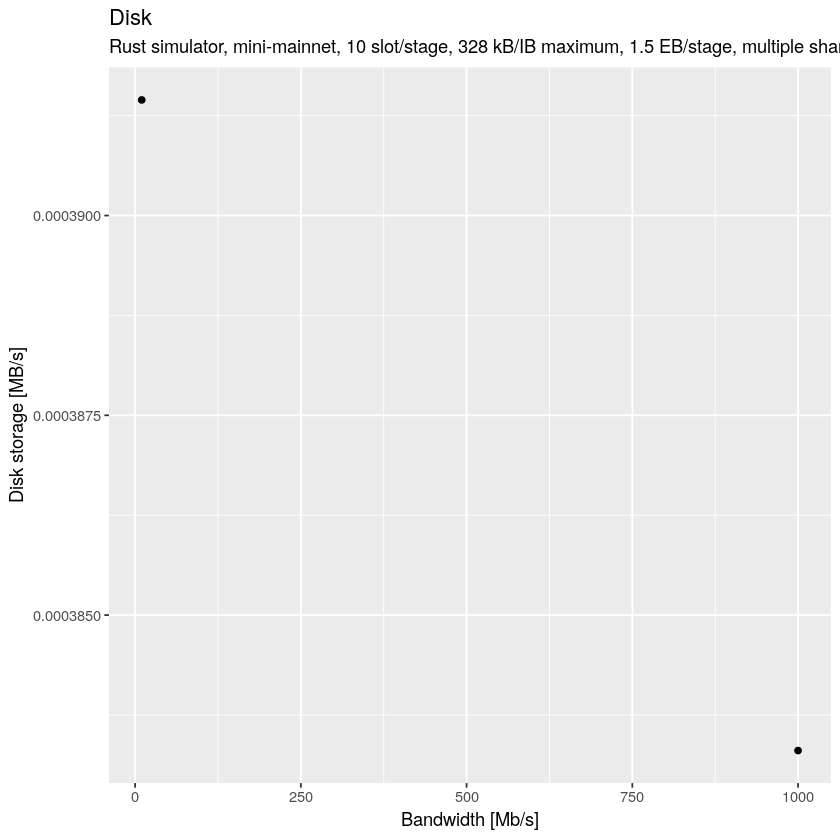

In [41]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Bandwidth [Mb/s]`)],
    aes(x=`Bandwidth [Mb/s]`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [42]:
ggsave("plots/bw/disk.png", units="in", dpi=150, width=9.5, height=5.5)

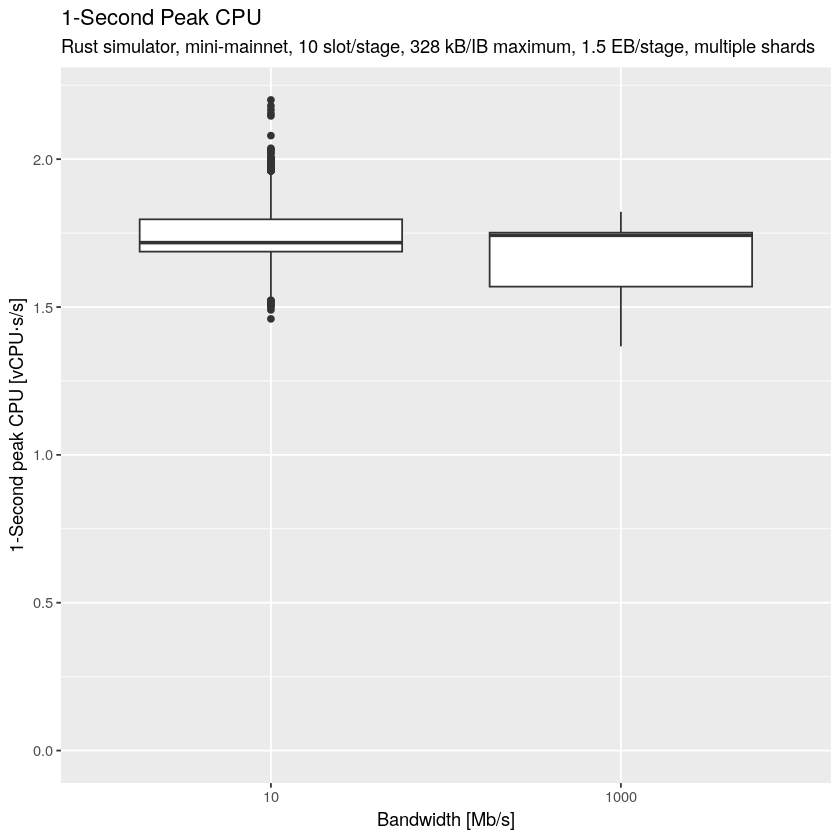

In [43]:
ggplot(
    resources[, .(`Node`, `Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Bandwidth [Mb/s]`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("1-Second Peak CPU", label)

In [44]:
ggsave("plots/bw/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

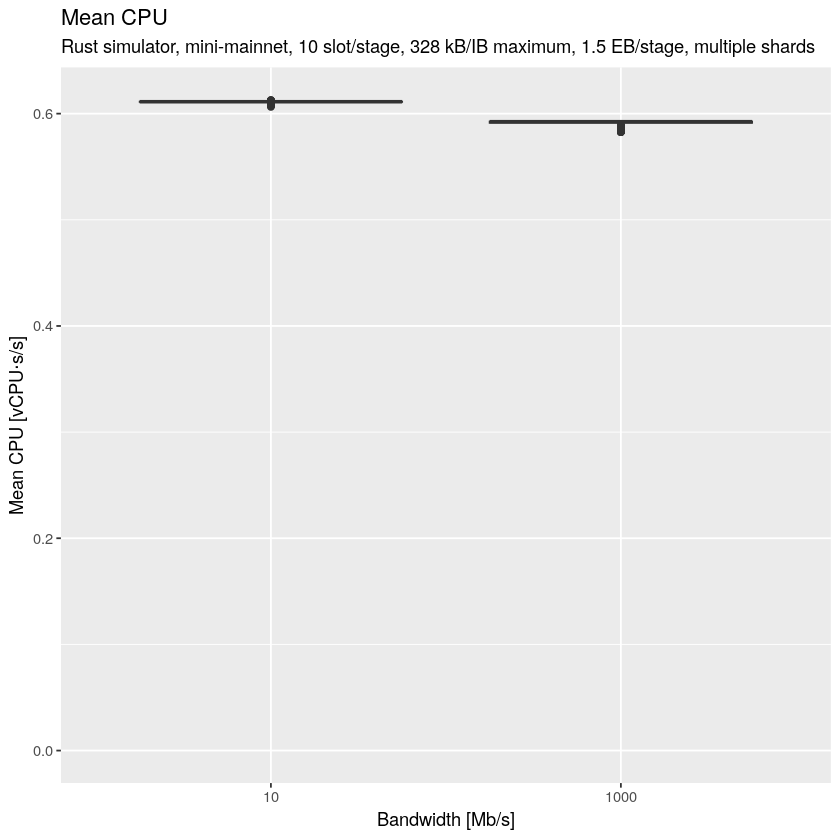

In [45]:
ggplot(
    resources[, .(`Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Bandwidth [Mb/s]`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("Mean CPU", label)

In [46]:
ggsave("plots/bw/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [47]:
rm(resources)

### Receipt of messages

#### Read results

In [48]:
receipts <- fread("results/bw/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

 Simulator       Bandwidth [Mb/s] Kind                    Item         
 Rust:71039324   Min.   :  10     EB:   35952   110-node-530:    2996  
                 1st Qu.:  10     IB:  584381   110-node-572:    2996  
                 Median :  10     RB:   16478   130-node-96 :    2996  
                 Mean   : 495     TX:67527851   140-node-563:    2996  
                 3rd Qu.:1000     VT: 2874662   140-node-99 :    2996  
                 Max.   :1000                   160-node-498:    2996  
                                                (Other)     :71021348  
     Producer        Generated [s]        Size [B]         Recipient       
 node-500:  136193   Min.   :  0.001   Min.   :     8   node-508:   94832  
 node-675:  135567   1st Qu.: 93.239   1st Qu.:   395   node-226:   94830  
 node-143:  133266   Median :128.629   Median :   871   node-310:   94829  
 node-6  :  133200   Mean   :127.961   Mean   :  2842   node-321:   94825  
 node-431:  130192   3rd Qu.:161.784   3rd Q

In [49]:
bwLevels <- paste(receipts[, sort(unique(`Bandwidth [Mb/s]`), decreasing=TRUE)], "Mb/s")
bwFactor <- function(bw) factor(paste(bw, "Mb/s"), levels=bwLevels)

In [50]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [51]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

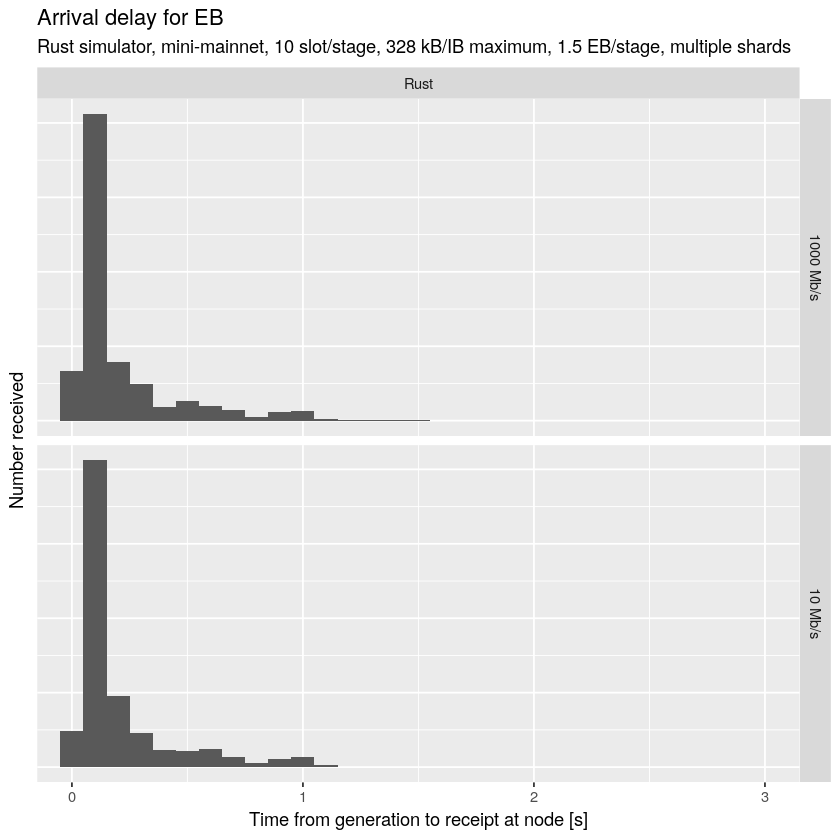

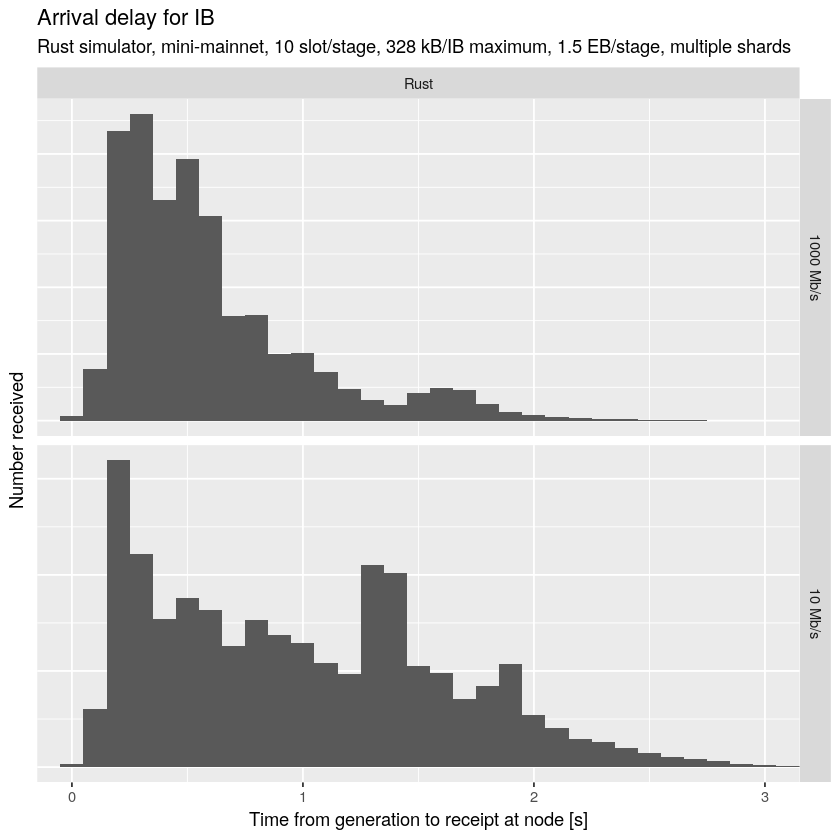

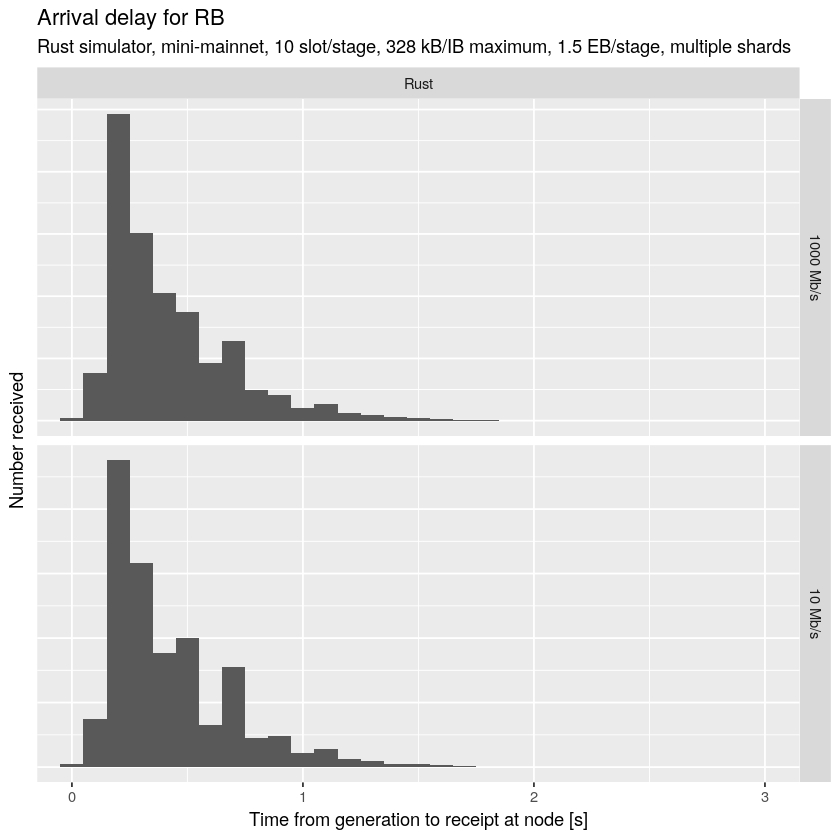

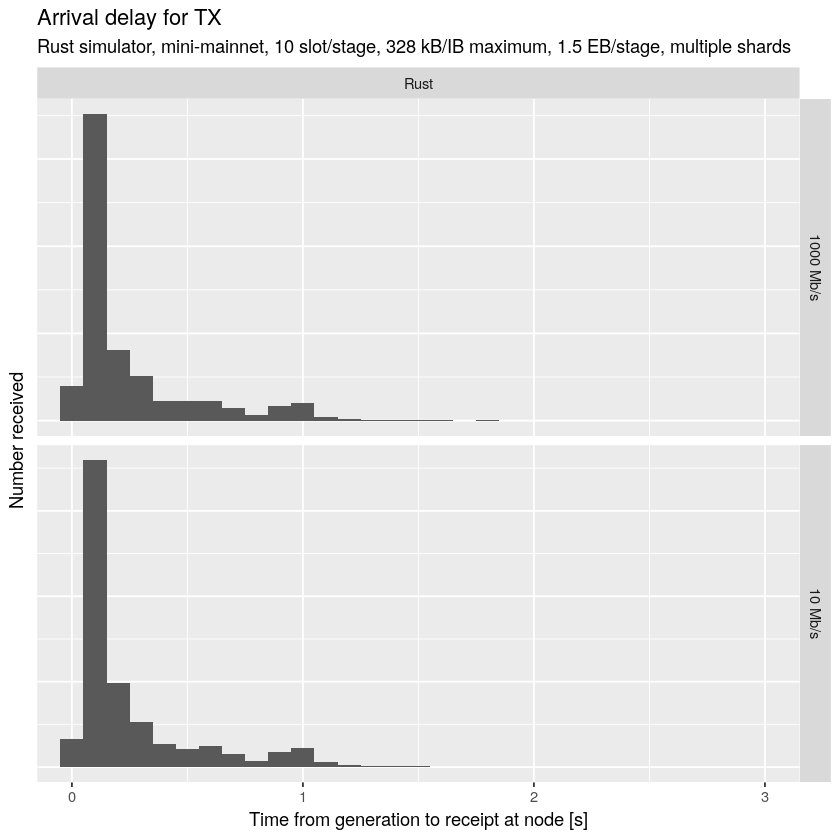

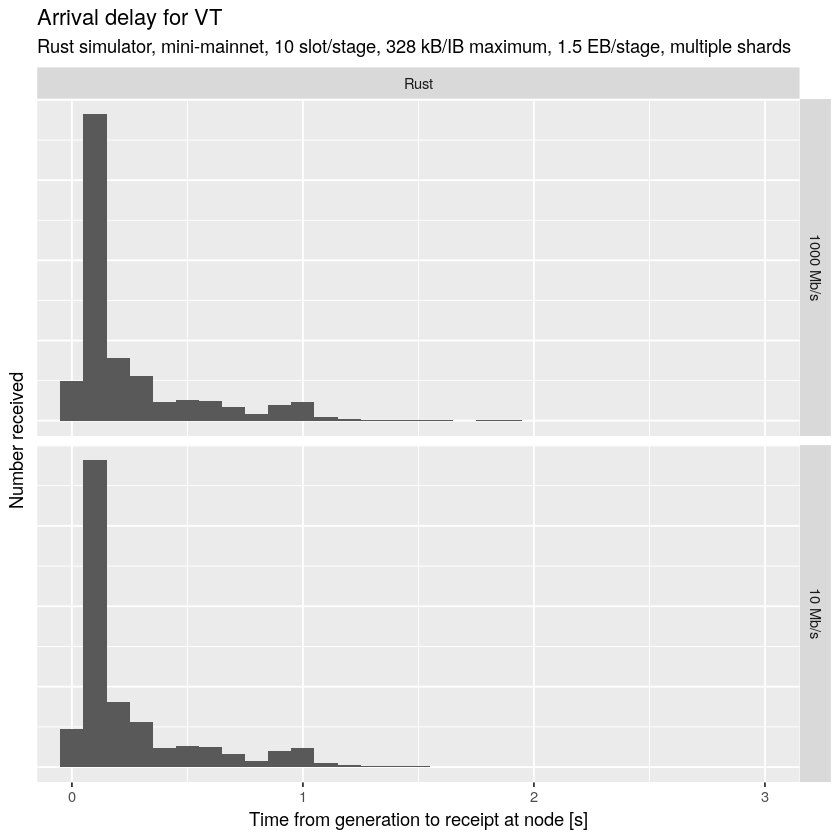

In [52]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/bw/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [53]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`)
        ][, .(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Bandwidth [Mb/s]`  ~ `Simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

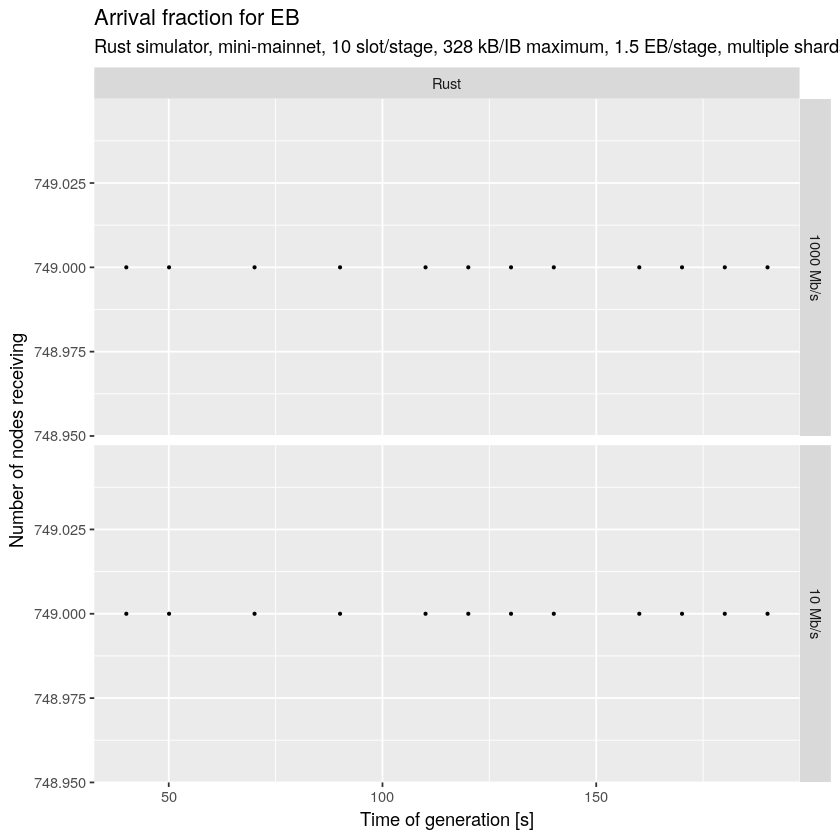

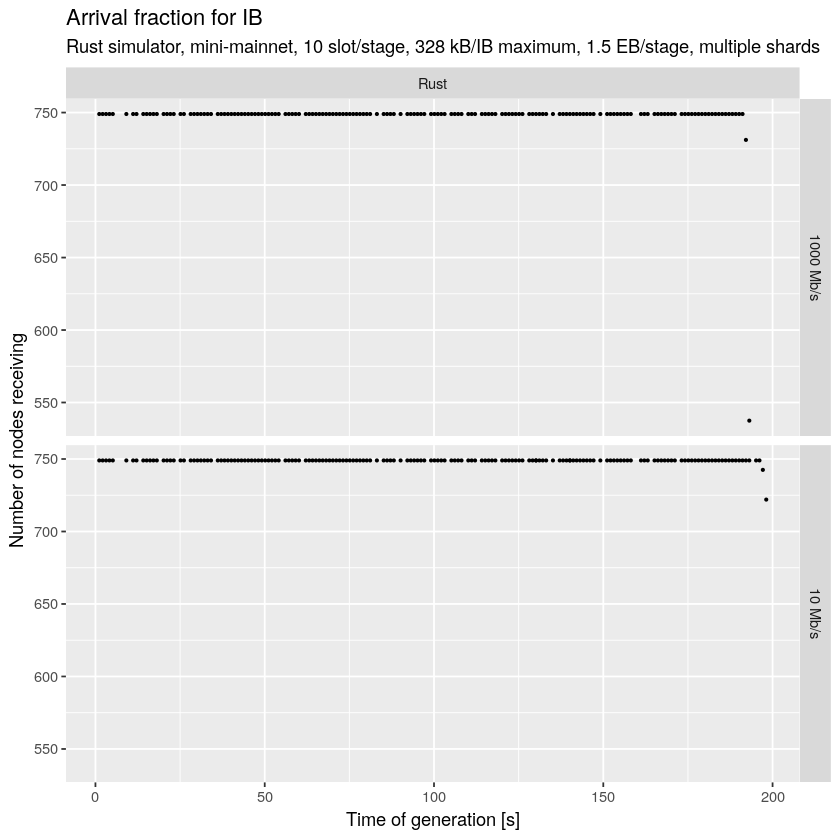

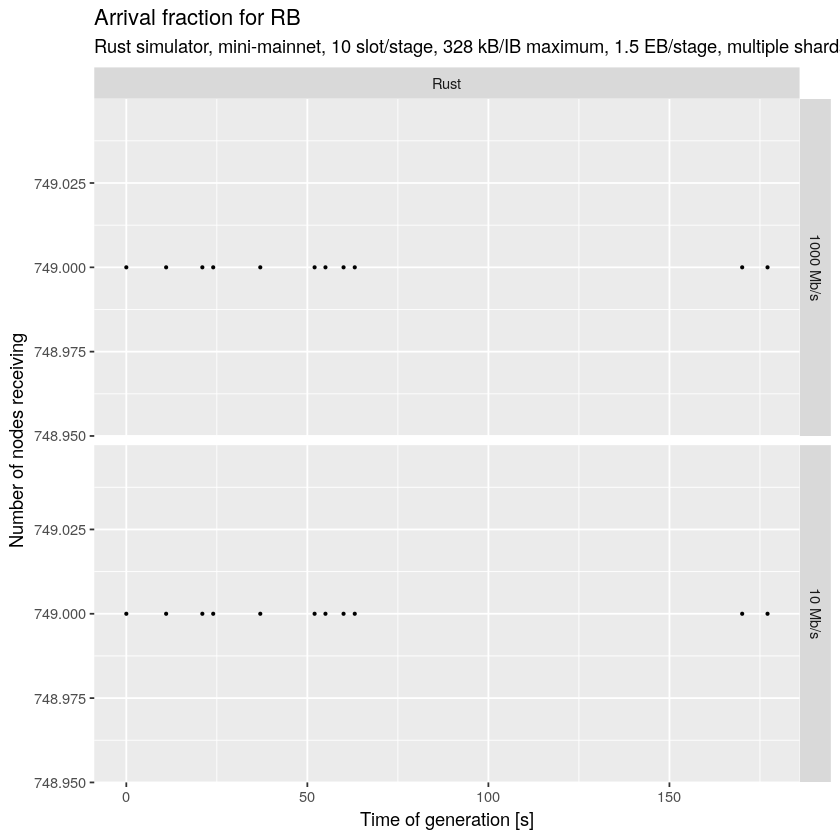

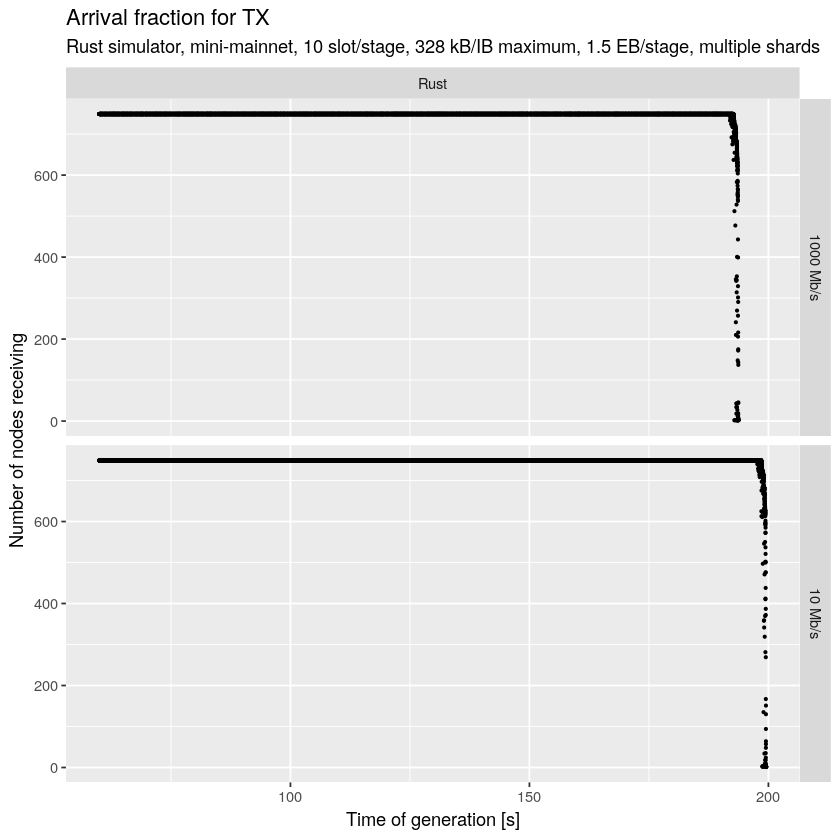

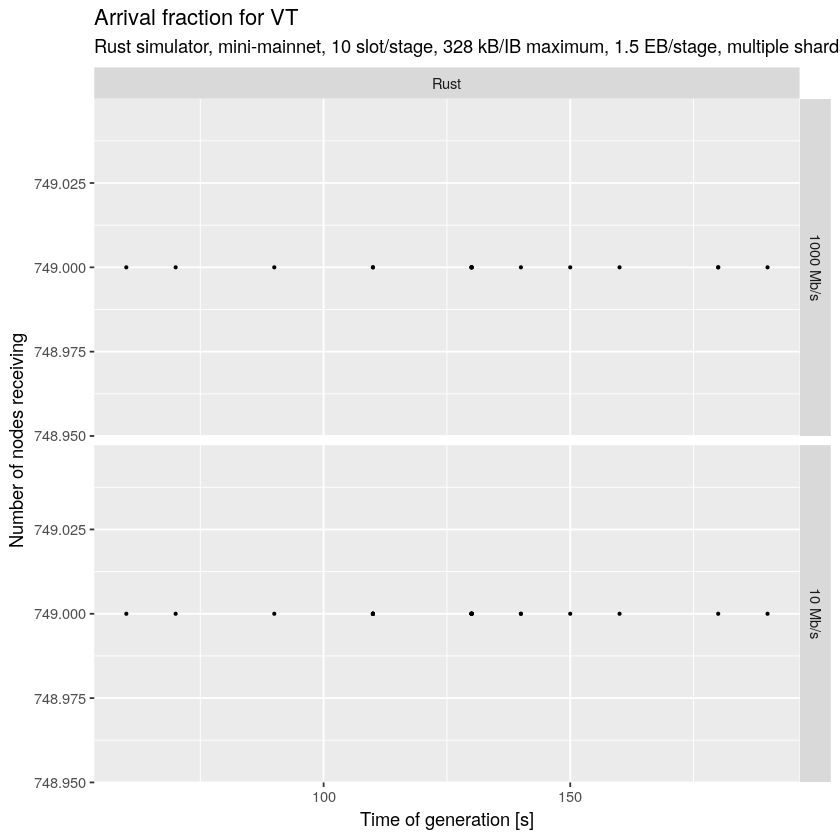

In [54]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/bw/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [55]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

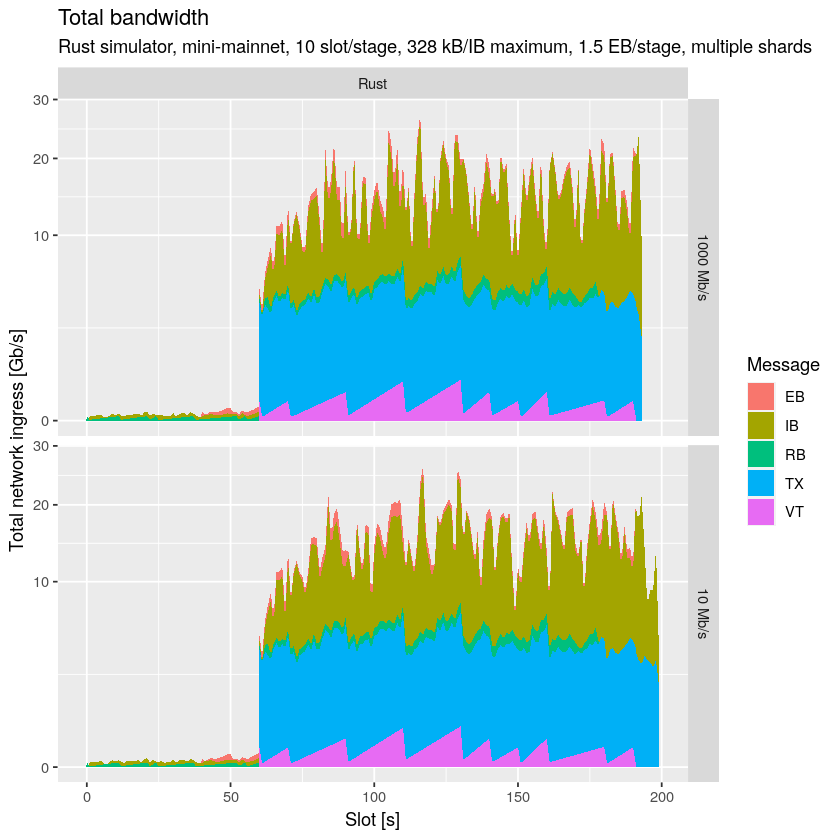

In [56]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/bw/ingress-total-area.png")
)

##### Bandwidth usage per node

In [57]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [58]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

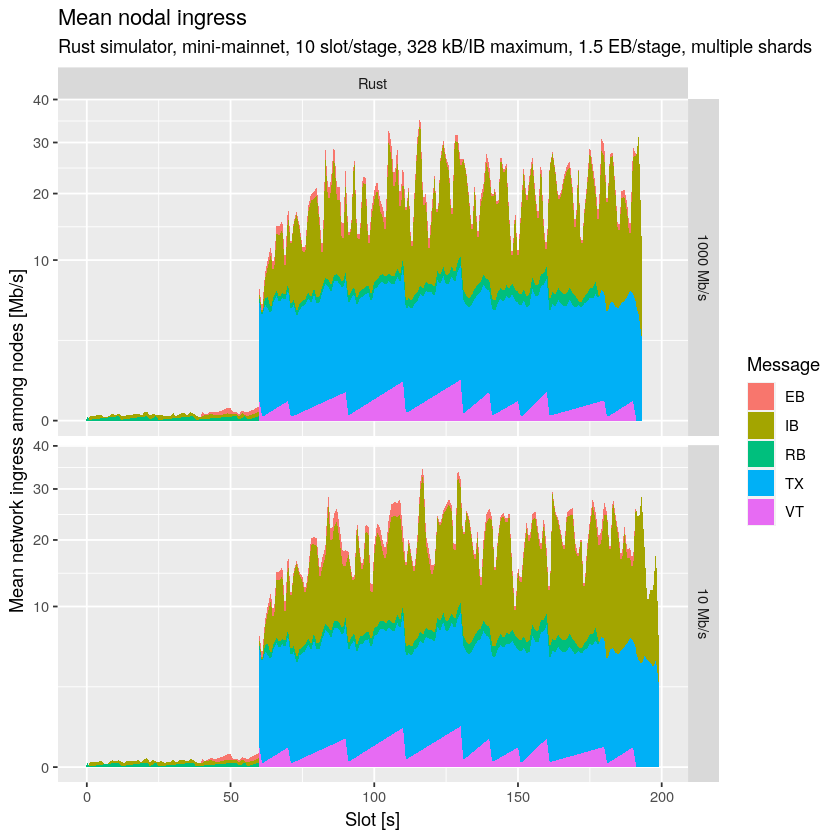

In [59]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/bw/ingress-average-area.png")
)

In [60]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

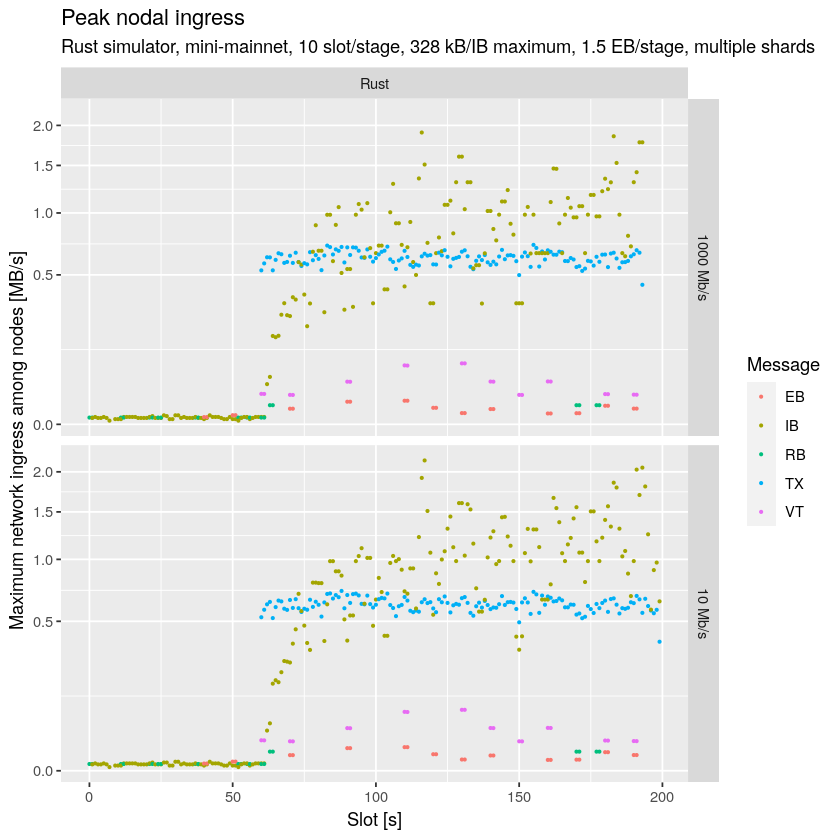

In [61]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/bw/ingress-peak-point.png")
)

#### Release memory

In [62]:
rm(receipts)

### CPU usage

#### Read results

In [63]:
cpus <- fread("results/bw/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

 Simulator       Bandwidth [Mb/s]      Slot             Node         
 Rust:74229887   Min.   :  10.0   Min.   :  0.0   node-508:   99081  
                 1st Qu.:  10.0   1st Qu.: 93.0   node-226:   99079  
                 Median :  10.0   Median :129.0   node-12 :   99078  
                 Mean   : 495.4   Mean   :127.4   node-310:   99078  
                 3rd Qu.:1000.0   3rd Qu.:160.0   node-321:   99074  
                 Max.   :1000.0   Max.   :199.0   node-213:   99072  
                                                  (Other) :73635425  
      Task           Duration [s]     
 ValTX  :67527829   Min.   :0.000164  
 ValVote: 5472194   1st Qu.:0.001500  
 ValIH  :  584896   Median :0.001500  
 ValIB  :  584381   Mean   :0.002430  
 ValEB  :   35952   3rd Qu.:0.001500  
 ValRB  :   16478   Max.   :0.213840  
 (Other):    8157                     

In [64]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `Simulator`,
        `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [65]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

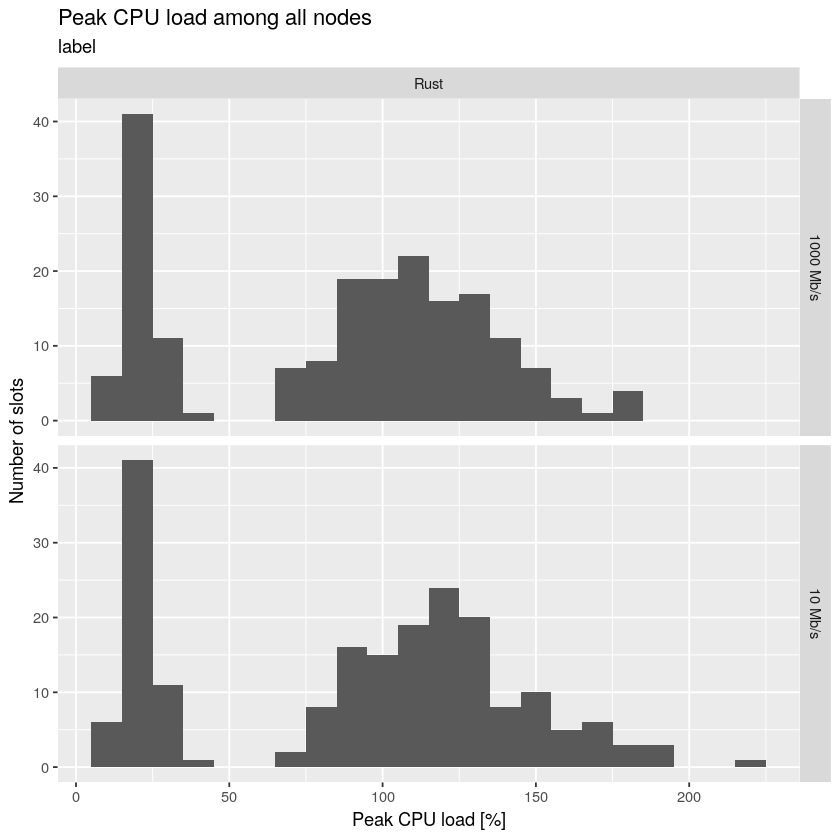

In [66]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/bw/cpu-peak-histogram.png")
)

##### Time series

In [67]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

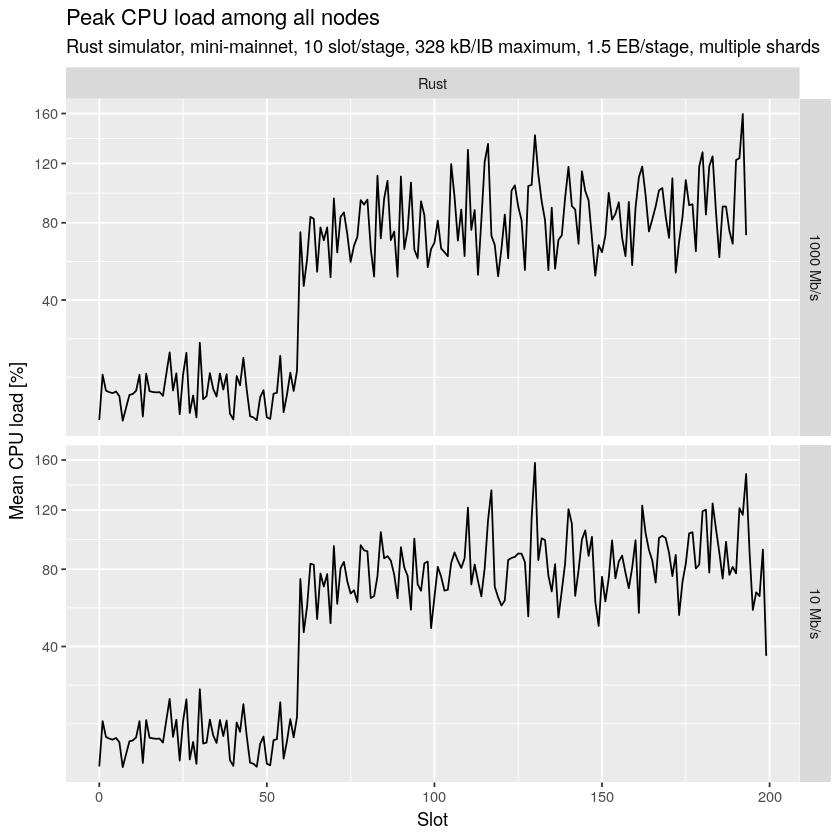

In [68]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/bw/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [69]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

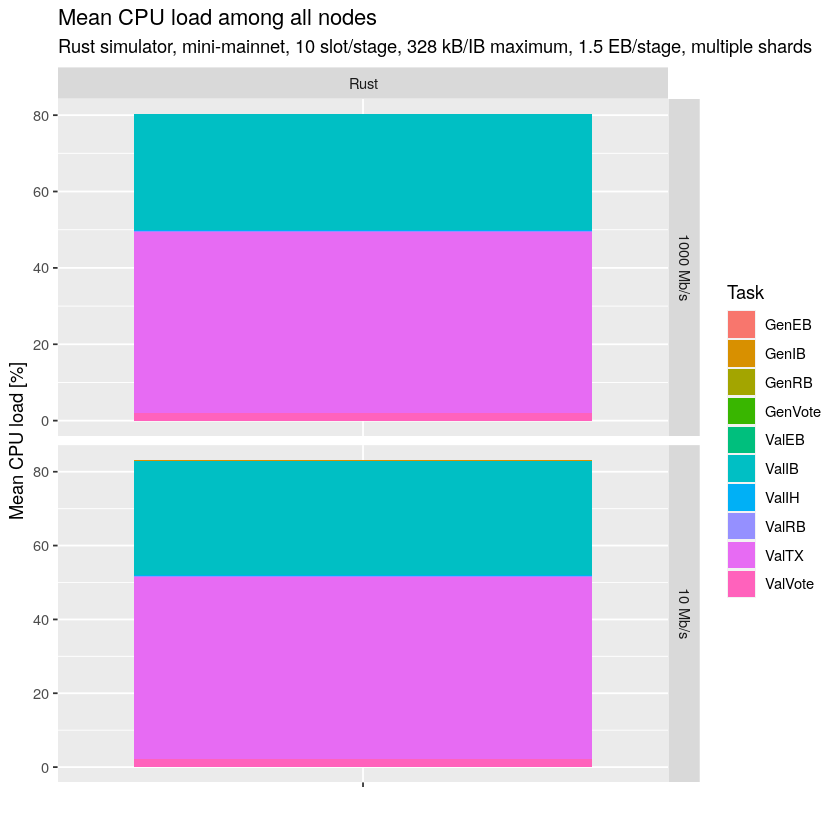

In [70]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/bw/cpu-mean-histogram.png")
)

##### Time series

In [71]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

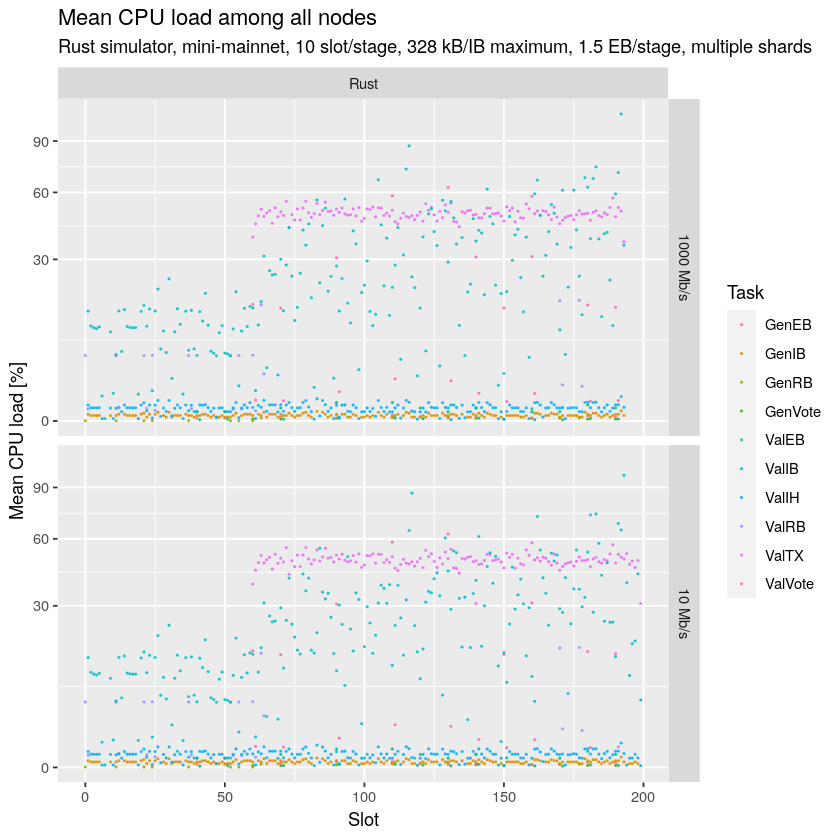

In [72]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/bw/cpu-mean-timeseries.png")
)

#### Release memory

In [73]:
rm(cpus, cpusNode)